# Imports

In [19]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

## Read Respiratory Cycle Data

In [20]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [21]:
import os
from collections import Counter

# Ścieżka do katalogu z plikami audio
directory_path = "../audio_and_txt_files_train_val"

# Pobierz listę plików w katalogu
filenames = [f for f in os.listdir(directory_path) if f.endswith('.wav')]
# print(filenames)

def extract_last_component(filename):
    base_name = os.path.splitext(filename)[0]
    components = base_name.split('_')
    return components[-1]

last_components = [extract_last_component(filename) for filename in filenames]
component_counts = Counter(last_components)

for component, count in component_counts.items():
    print(f"{component}: {count}")

import pandas as pd

df = pd.DataFrame(component_counts.items(), columns=['Component', 'Count'])
print(df)



Meditron: 113
LittC2SE: 77
Litt3200: 56
AKGC417L: 582
  Component  Count
0  Meditron    113
1  LittC2SE     77
2  Litt3200     56
3  AKGC417L    582


In [22]:
root = directory_path

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

rec_annotations_dict

{'101_1b1_Al_sc_Meditron':      Start     End  Crackles  Wheezes
 0    0.036   0.579         0        0
 1    0.579   2.450         0        0
 2    2.450   3.893         0        0
 3    3.893   5.793         0        0
 4    5.793   7.521         0        0
 5    7.521   9.279         0        0
 6    9.279  11.150         0        0
 7   11.150  13.036         0        0
 8   13.036  14.721         0        0
 9   14.721  16.707         0        0
 10  16.707  18.507         0        0
 11  18.507  19.964         0        0,
 '102_1b1_Ar_sc_Meditron':      Start     End  Crackles  Wheezes
 0    0.264   1.736         0        0
 1    1.736   3.293         0        0
 2    3.293   5.307         0        0
 3    5.307   6.636         0        0
 4    6.636   8.036         0        0
 5    8.036   9.607         0        0
 6    9.607  11.036         0        0
 7   11.036  13.036         0        0
 8   13.036  14.664         0        0
 9   14.664  16.393         0        0
 10  16.393

## Get Respiratory Cycle length and Diagnosis

In [23]:
res_rate_list = []
for i in range (828):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i], columns=['Start'])
    count = cycle_df.count(axis=0)
    df = pd.DataFrame(count).T
    res_rate_list.append(df)
res_rate_list

[   Start
 0     12,
    Start
 0     13,
    Start
 0      6,
    Start
 0      6,
    Start
 0     14,
    Start
 0      7,
    Start
 0      5,
    Start
 0     13,
    Start
 0     10,
    Start
 0      8,
    Start
 0      9,
    Start
 0      9,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      8,
    Start
 0      9,
    Start
 0     10,
    Start
 0      8,
    Start
 0      9,
    Start
 0     15,
    Start
 0      7,
    Start
 0      7,
    Start
 0 

In [24]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename']
res_rate_df.sort_values(by=['filename'])

,Start,filename
0,12,101_1b1_Al_sc_Meditron
1,13,102_1b1_Ar_sc_Meditron
2,6,103_2b2_Ar_mc_LittC2SE
3,6,104_1b1_Al_sc_Litt3200
4,14,104_1b1_Ar_sc_Litt3200
...,...,...
823,7,224_1b1_Tc_sc_Meditron
824,14,225_1b1_Pl_sc_Meditron
825,10,226_1b1_Al_sc_Meditron
826,10,226_1b1_Ll_sc_Meditron


## Save Diagnosis Data

In [25]:
res_rate_df.to_csv('cycles_count.csv')

## Data Augmentation

In [26]:
audio_data = "../audio_and_txt_files_train_val/"

In [27]:
rr_diagnosis_df = pd.read_csv('cycles_count.csv', names=['cycles', 'filename'],header=0)
rr_diagnosis_df.head(4)

,cycles,filename
0,12,101_1b1_Al_sc_Meditron
1,13,102_1b1_Ar_sc_Meditron
2,6,103_2b2_Ar_mc_LittC2SE
3,6,104_1b1_Al_sc_Litt3200


In [28]:
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [29]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':             
            
            label = list(data[data['filename']==(soundDir[:-4])]['cycles'])[0]

            data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
            
            mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            
            X_.append(mfccs)
            y_.append(label)
            
            data_shift = shift(data_x,1600)
            mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_shift)
            y_.append(label)
            
            data_noise = add_noise(data_x,0.005)
            mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_noise)
            y_.append(label)
                
    X_data = np.array(X_)
    y_data = np.array(y_)    
    
    return X_data ,y_data

In [30]:
res_data, res_y = mfcc_feature_exteraction_rr(audio_data)

In [31]:
res_features = np.array(res_data)
res_lables = np.array(res_y)

res_features.shape , res_lables.shape

((2484, 50), (2484,))

## Data Split

In [32]:
x_train, x_val, y_train, y_val  = train_test_split(res_features, res_lables, test_size=0.175, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)

print (x_train.shape, x_val.shape, x_test.shape)
print (y_train.shape, y_val.shape, y_test.shape)

(1895, 50) (435, 50) (154, 50)
(1895,) (435,) (154,)


# LSTM Model

In [33]:
x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)
x_test_lstm = np.expand_dims(x_test,axis=2)

## Build Model

In [34]:
# Define the model
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))

model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train Model

In [35]:
history = model.fit(
    x_train_lstm, y_train, batch_size=16, epochs=150, validation_data=(x_val_lstm, y_val),
  )
model.save("model_train_val.h5")
model.save_weights('model_train_val.weights.h5')
import pickle
with open('model_train_val', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 141s 682ms/step - loss: 54.0905 - mae: 6.2461 - val_loss: 17.2744 - val_mae: 2.6987
Epoch 2/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 77s 647ms/step - loss: 26.7164 - mae: 3.8568 - val_loss: 14.8263 - val_mae: 2.4764
Epoch 3/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 84s 659ms/step - loss: 24.1131 - mae: 3.6367 - val_loss: 13.7165 - val_mae: 2.3702
Epoch 4/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 683ms/step - loss: 20.8946 - mae: 3.4959 - val_loss: 17.1619 - val_mae: 2.7206
Epoch 5/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 669ms/step - loss: 19.7856 - mae: 3.3558 - val_loss: 12.3087 - val_mae: 2.2649
Epoch 6/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 657ms/step - loss: 19.5191 - mae: 3.1521 - val_loss: 15.9156 - val_mae: 2.5488
Epoch 7/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 669ms/step - loss: 19.6885 - mae: 3.2281 - val_loss: 12.9890 - val_mae: 2.3388
Epoch 8/150
119/119 ━━━━━━━━━━━━━━━━━━━━ 81s 658ms/step - loss: 17.6798 - mae: 3.0451 - val_loss: 12.2627 - val_mae: 2.2743
Epoch 9

## Evaluate Model

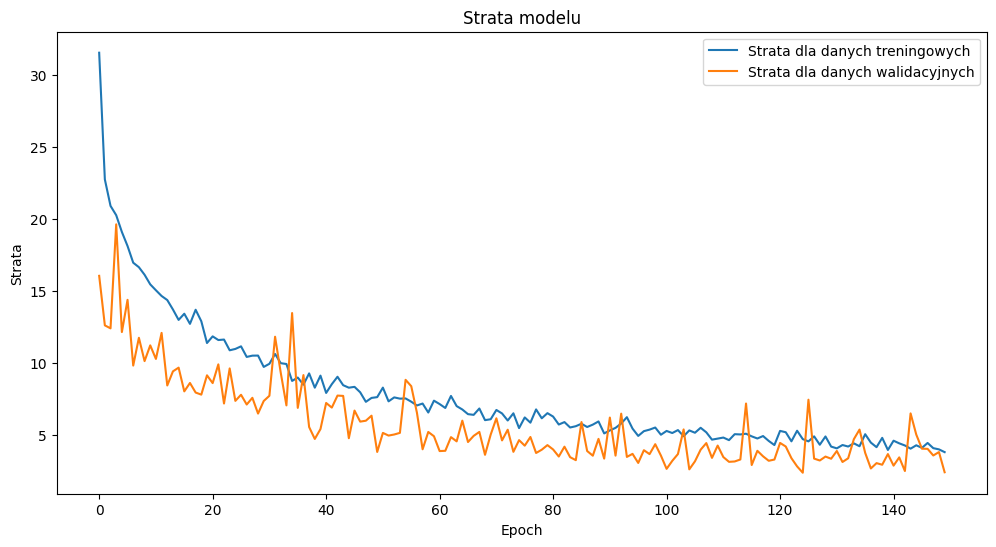

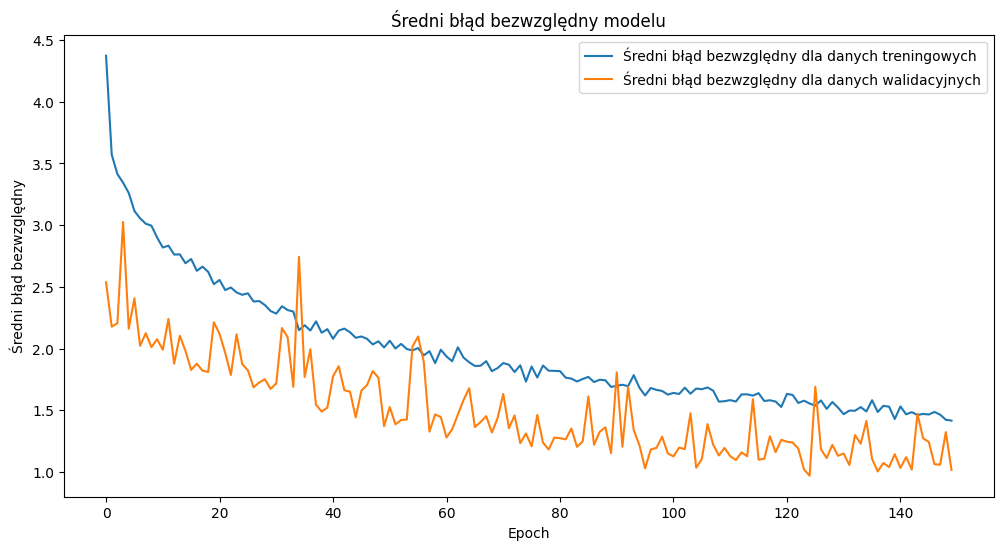

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


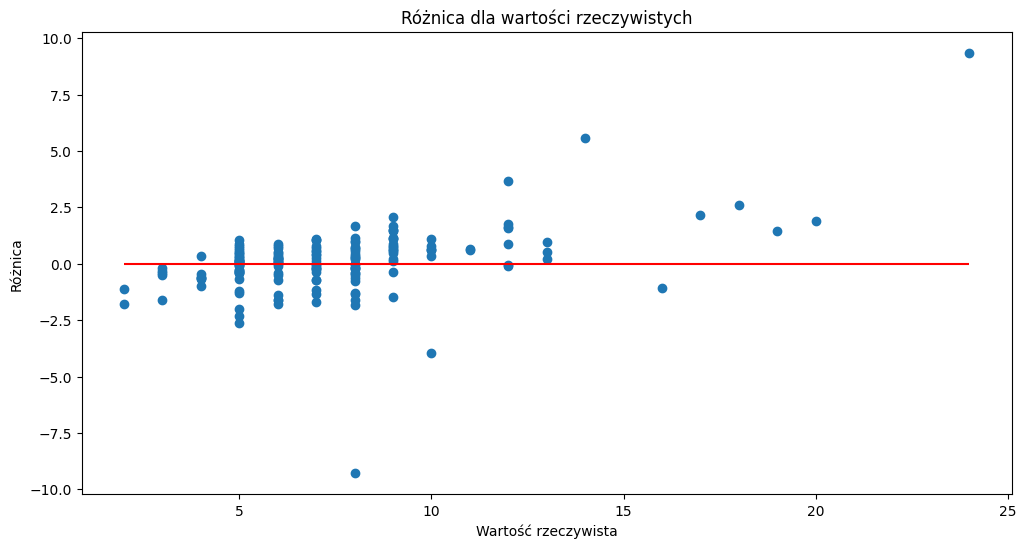

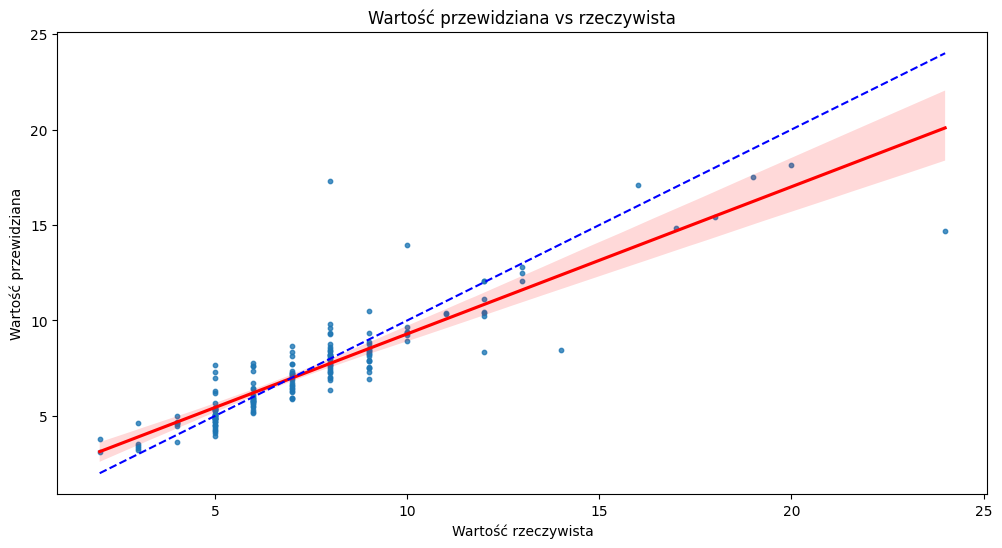

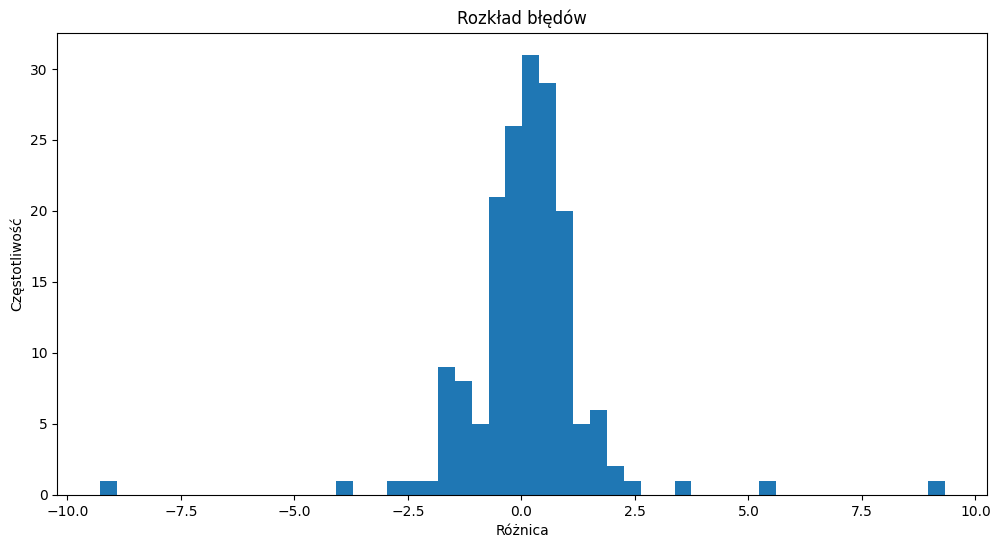

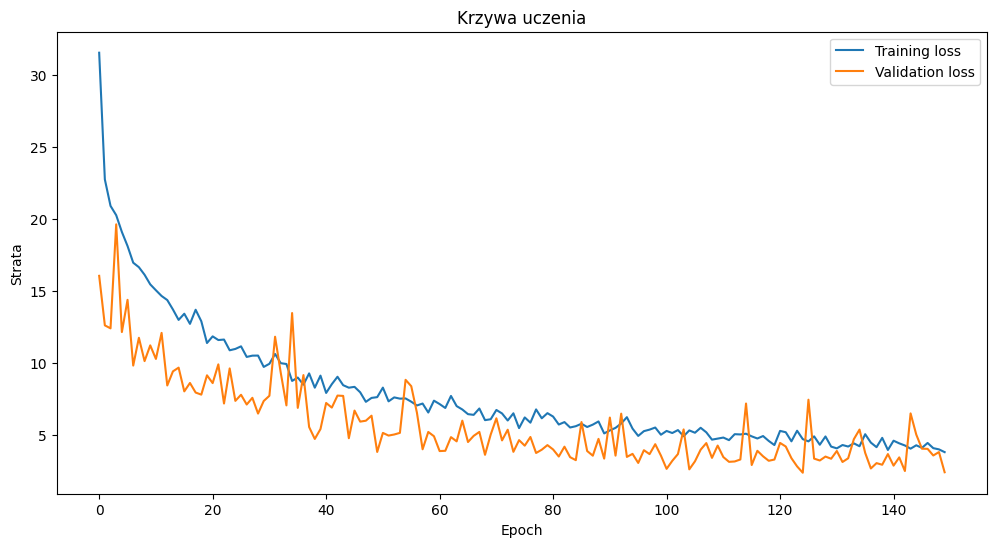

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from keras.models import load_model
# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)
model = load_model("model.h5")
model.load_weights('model.weights.h5')

import os
if not os.path.isdir("plots_training"):
    os.makedirs('plots_training')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Strata dla danych treningowych')
plt.plot(history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.savefig("plots_training/Strata dla danych treningowych")
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.savefig("plots_training/Średni błąd bezwzględny dla danych treningowych")
plt.show()

# Make predictions
y_pred = model.predict(x_test_lstm)

# Residuals Plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r')
plt.title('Różnica dla wartości rzeczywistych')
plt.xlabel('Wartość rzeczywista')
plt.ylabel('Różnica')
plt.savefig("plots_training/Różnica dla wartości rzeczywistych")
plt.show()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Załóżmy, że y_test i y_pred są dostępne jako NumPy array
y_test = np.array(y_test).ravel()  # Upewnij się, że y_test jest jednowymiarowy
y_pred = np.array(y_pred).ravel()  # Upewnij się, że y_pred jest jednowymiarowy

# Przekształć dane na DataFrame
df = pd.DataFrame({'Wartość rzeczywista': y_test, 'Wartość przewidziana': y_pred})

# Wykres Wartość przewidziana vs rzeczywista z regresją liniową
plt.figure(figsize=(12, 6))
sns.regplot(x='Wartość rzeczywista', y='Wartość przewidziana', data=df, scatter_kws={'s':10}, line_kws={"color": "red"})
plt.plot([min(df['Wartość rzeczywista']), max(df['Wartość rzeczywista'])], 
         [min(df['Wartość rzeczywista']), max(df['Wartość rzeczywista'])], 
         color='blue', linestyle='dashed')  # Linia idealnej predykcji
plt.title('Wartość przewidziana vs rzeczywista')
plt.xlabel('Wartość rzeczywista')
plt.ylabel('Wartość przewidziana')
plt.savefig("plots_training/Wartość przewidziana vs rzeczywista")
plt.show()


# Error Distribution (Histogram of residuals)
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.title('Rozkład błędów')
plt.xlabel('Różnica')
plt.ylabel('Częstotliwość')
plt.savefig("plots_training/Rozkład błędów")
plt.show()

# Learning Curves: Train vs Validation loss over batches
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.title('Krzywa uczenia')
    plt.xlabel('Epoch')
    plt.ylabel('Strata')
    plt.legend()
    plt.savefig("plots_training/Krzywa uczenia")
    plt.show()

plot_learning_curves(history)


# Call the function to create the comprehensive plot
# plot_all_metrics(history, x_test_lstm, y_test, y_pred)


In [22]:
loss, mae = model.evaluate(x_test_lstm, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.8724 - mean_absolute_error: 0.8486
Test Loss: 2.1677870750427246
Test MAE: 0.8692985773086548


In [1]:
import numpy as np
import librosa
from keras.models import load_model

def respiratory_rate_prediction(audio_path):
    # Load audio with 22050 Hz sampling rate
    # data_x, sampling_rate = librosa.load(audio_path, sr=22050)
    data_x, sampling_rate = librosa.load(audio_path, res_type='kaiser_fast')
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features)[0][0]

    print(f'Predicted Respiratory Rate: {predicted_value}')

respiratory_rate_prediction("C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav")

NameError: name 'model' is not defined

In [122]:
res_y[1]

34.5845487415067

In [123]:
rr_diagnosis_df

,patient_id,respiratory_rate
0,101,34.584549
1,102,39.593909
2,103,18.353301
3,104,26.274026
4,105,24.155805
...,...,...
121,222,12.113927
122,223,19.402063
123,224,21.060549
124,225,42.120042
